In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Add, Activation, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [17]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Load datasets
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'

In [19]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [20]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [21]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

In [22]:
# Define a function to create sequences and perform forecasting
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length][0]  # Predicting 'Price'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [23]:
def rolling_forecast_future(model, data, steps, scaler, window_size=30):
    forecast = []
    last_sequence = data[-window_size:]

    for _ in range(steps // window_size):
        predictions = []

        for _ in range(window_size):
            prediction = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
            predictions.append(prediction[0][0])
            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1, 0] = prediction[0][0]

        forecast.extend(predictions)

    forecast = np.array(forecast)
    forecast_with_features = np.zeros((forecast.shape[0], data.shape[1]))
    forecast_with_features[:, 0] = forecast  # Fill in the 'Price' predictions

    forecast_with_features = scaler.inverse_transform(forecast_with_features)
    forecast_prices = forecast_with_features[:, 0]  # Extract the 'Price' column

    return forecast_prices

In [24]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [25]:
def build_res_cnn_block(input_layer):
    conv1 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(input_layer)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='linear')(conv2)
    skip_connection = Add()([conv1, conv2])
    skip_connection = Activation('relu')(skip_connection)
    return skip_connection

In [26]:
def build_rescnn_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    res_cnn_block1 = build_res_cnn_block(input_layer)
    res_cnn_block2 = build_res_cnn_block(res_cnn_block1)
    lstm_layer = LSTM(64, return_sequences=False)(res_cnn_block2)
    dense1 = Dense(32, activation='relu')(lstm_layer)
    output_layer = Dense(1, activation='linear')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [27]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=1):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    predicted_prices = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, predicted_prices)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
    mape = np.mean(np.abs((y_test - predicted_prices) / y_test)) * 100
    return predicted_prices, mae, rmse, mape

In [28]:
def process_dataset(df, dataset_name, split_ratio):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']])

    # Create sequences
    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    # Build and train model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rescnn_lstm_model(input_shape)
    predicted_prices, mae, rmse, mape = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100)

    # Inverse transform to get actual prices
    y_test_reshaped = y_test.reshape(-1, 1)
    predicted_prices_reshaped = predicted_prices.reshape(-1, 1)
    actual_prices = scaler.inverse_transform(np.hstack((y_test_reshaped, np.zeros((y_test_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]
    predicted_prices_actual = scaler.inverse_transform(np.hstack((predicted_prices_reshaped, np.zeros((predicted_prices_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    # Rolling forecast future prices
    forecast_30 = rolling_forecast_future(model, scaled_data, 30, scaler)
    forecast_60 = rolling_forecast_future(model, scaled_data, 60, scaler)
    forecast_90 = rolling_forecast_future(model, scaled_data, 90, scaler)

    forecast_dates_30 = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')
    forecast_dates_60 = pd.date_range(start=df['Date'].iloc[-1], periods=60, freq='D')
    forecast_dates_90 = pd.date_range(start=df['Date'].iloc[-1], periods=90, freq='D')

    plt.plot(forecast_dates_30, forecast_30, color='brown', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_60[30:], forecast_60[30:], color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_90[60:], forecast_90[60:], color='red', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'ResCNN {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

In [29]:
# Define datasets and split ratios
datasets = {'Bitcoin': bitcoin_df, 'NASDAQ': nasdaq_df, 'US Dollar Index': usd_df}
split_ratios = [0.7, 0.8, 0.6]

Epoch 1/100
90/90 [==============================] - 7s 28ms/step - loss: 5.5630e-04 - val_loss: 0.0017
Epoch 2/100
90/90 [==============================] - 2s 17ms/step - loss: 1.3934e-04 - val_loss: 9.4244e-04
Epoch 3/100
90/90 [==============================] - 1s 16ms/step - loss: 8.2487e-05 - val_loss: 0.0025
Epoch 4/100
90/90 [==============================] - 2s 17ms/step - loss: 6.5753e-05 - val_loss: 6.4045e-04
Epoch 5/100
90/90 [==============================] - 2s 18ms/step - loss: 4.1832e-05 - val_loss: 6.3008e-04
Epoch 6/100
90/90 [==============================] - 2s 25ms/step - loss: 5.7564e-05 - val_loss: 0.0018
Epoch 7/100
90/90 [==============================] - 2s 25ms/step - loss: 3.6121e-05 - val_loss: 0.0025
Epoch 8/100
90/90 [==============================] - 1s 16ms/step - loss: 4.6503e-05 - val_loss: 0.0012
Epoch 9/100
90/90 [==============================] - 2s 17ms/step - loss: 4.8507e-05 - val_loss: 0.0012
Epoch 10/100
90/90 [==============================] 

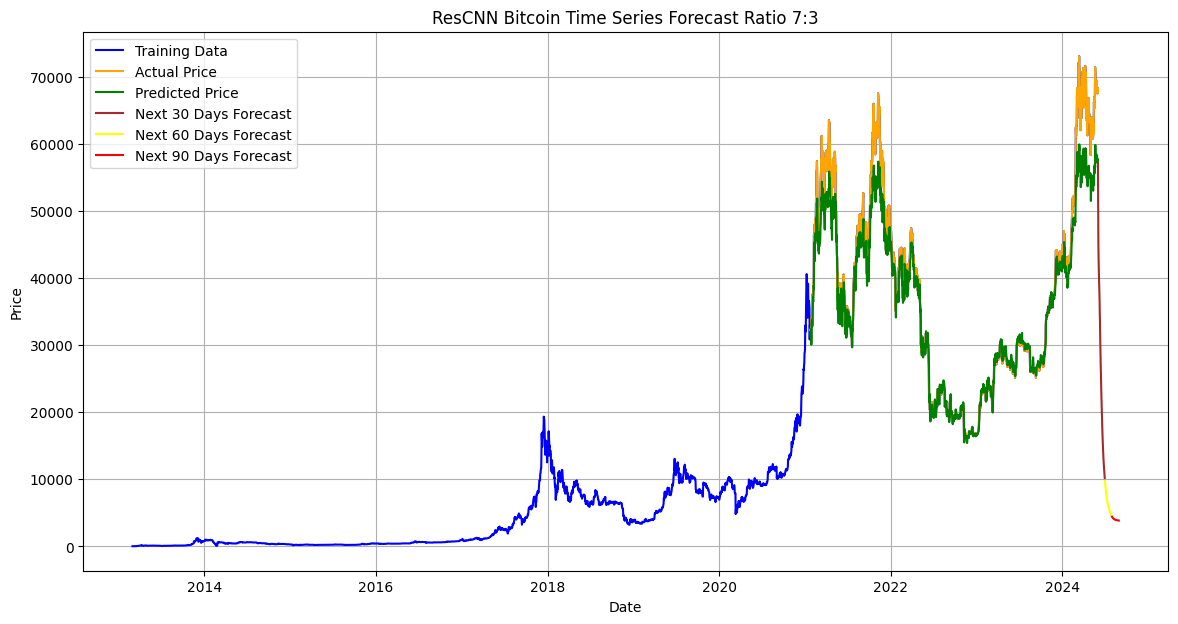

Bitcoin Results (Ratio 7:3): MAE: 0.0316, RMSE: 0.0521, MAPE: 4.72%
Epoch 1/100
102/102 [==============================] - 5s 20ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 2/100
102/102 [==============================] - 1s 15ms/step - loss: 4.7839e-04 - val_loss: 0.0011
Epoch 3/100
102/102 [==============================] - 1s 14ms/step - loss: 4.7543e-04 - val_loss: 0.0014
Epoch 4/100
102/102 [==============================] - 3s 25ms/step - loss: 2.7865e-04 - val_loss: 4.0313e-04
Epoch 5/100
102/102 [==============================] - 2s 24ms/step - loss: 3.2029e-04 - val_loss: 3.8038e-04
Epoch 6/100
102/102 [==============================] - 2s 16ms/step - loss: 1.8901e-04 - val_loss: 2.8715e-04
Epoch 7/100
102/102 [==============================] - 1s 15ms/step - loss: 1.5616e-04 - val_loss: 0.0021
Epoch 8/100
102/102 [==============================] - 1s 15ms/step - loss: 2.3000e-04 - val_loss: 4.0889e-04
Epoch 9/100
102/102 [==============================] - 1s 15ms/step - lo

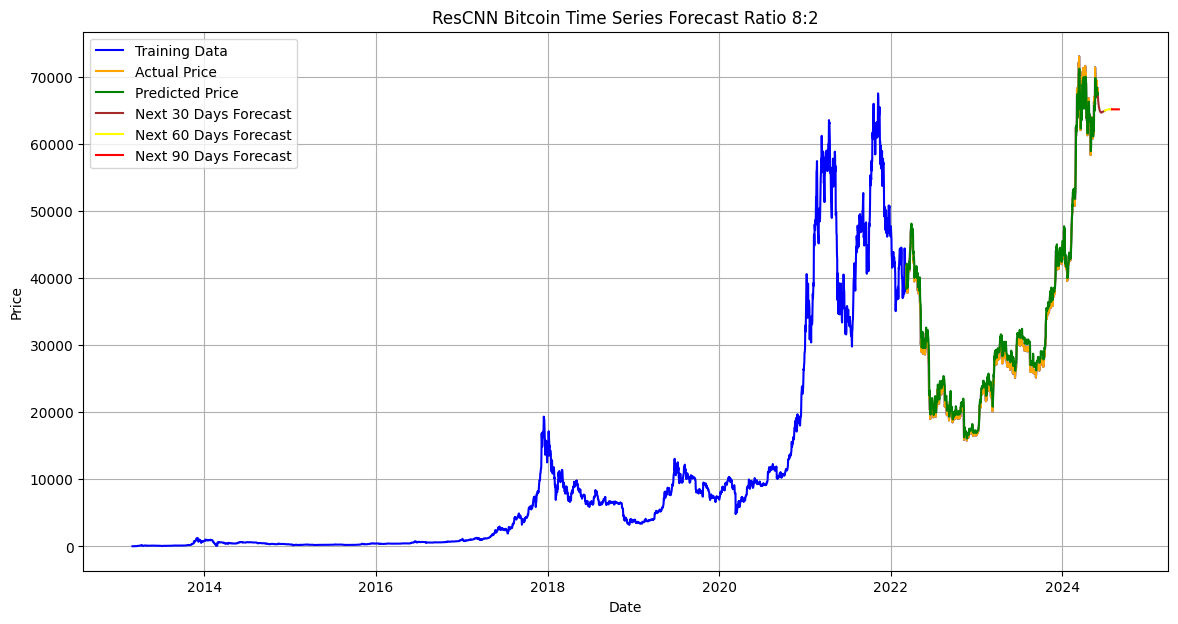

Bitcoin Results (Ratio 8:2): MAE: 0.0138, RMSE: 0.0176, MAPE: 3.33%
Epoch 1/100
77/77 [==============================] - 5s 26ms/step - loss: 3.4979e-04 - val_loss: 0.0088
Epoch 2/100
77/77 [==============================] - 1s 19ms/step - loss: 6.5754e-05 - val_loss: 0.0070
Epoch 3/100
77/77 [==============================] - 1s 19ms/step - loss: 3.7313e-05 - val_loss: 0.0017
Epoch 4/100
77/77 [==============================] - 2s 24ms/step - loss: 4.1636e-05 - val_loss: 0.0016
Epoch 5/100
77/77 [==============================] - 2s 27ms/step - loss: 2.5121e-05 - val_loss: 0.0048
Epoch 6/100
77/77 [==============================] - 2s 28ms/step - loss: 2.3150e-05 - val_loss: 0.0021
Epoch 7/100
77/77 [==============================] - 1s 18ms/step - loss: 2.7831e-05 - val_loss: 0.0046
Epoch 8/100
77/77 [==============================] - 1s 18ms/step - loss: 2.4449e-05 - val_loss: 0.0035
Epoch 9/100
77/77 [==============================] - 1s 19ms/step - loss: 2.1951e-05 - val_loss: 0.0

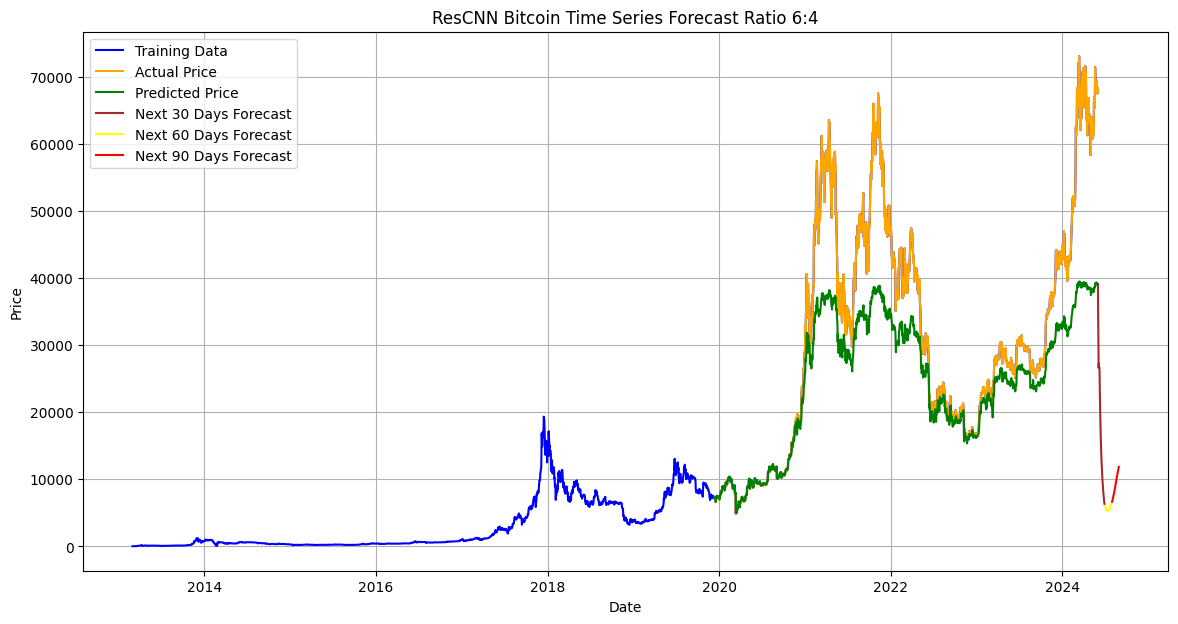

Bitcoin Results (Ratio 6:4): MAE: 0.0940, RMSE: 0.1451, MAPE: 15.17%
Epoch 1/100
62/62 [==============================] - 7s 35ms/step - loss: 0.0118 - val_loss: 0.0014
Epoch 2/100
62/62 [==============================] - 1s 17ms/step - loss: 2.3174e-04 - val_loss: 8.6233e-04
Epoch 3/100
62/62 [==============================] - 1s 17ms/step - loss: 1.8330e-04 - val_loss: 7.8945e-04
Epoch 4/100
62/62 [==============================] - 1s 17ms/step - loss: 1.6609e-04 - val_loss: 0.0011
Epoch 5/100
62/62 [==============================] - 1s 17ms/step - loss: 1.4476e-04 - val_loss: 5.8221e-04
Epoch 6/100
62/62 [==============================] - 1s 17ms/step - loss: 1.3046e-04 - val_loss: 6.9668e-04
Epoch 7/100
62/62 [==============================] - 1s 17ms/step - loss: 1.2246e-04 - val_loss: 4.8863e-04
Epoch 8/100
62/62 [==============================] - 1s 17ms/step - loss: 1.2007e-04 - val_loss: 4.2521e-04
Epoch 9/100
62/62 [==============================] - 1s 17ms/step - loss: 1.129

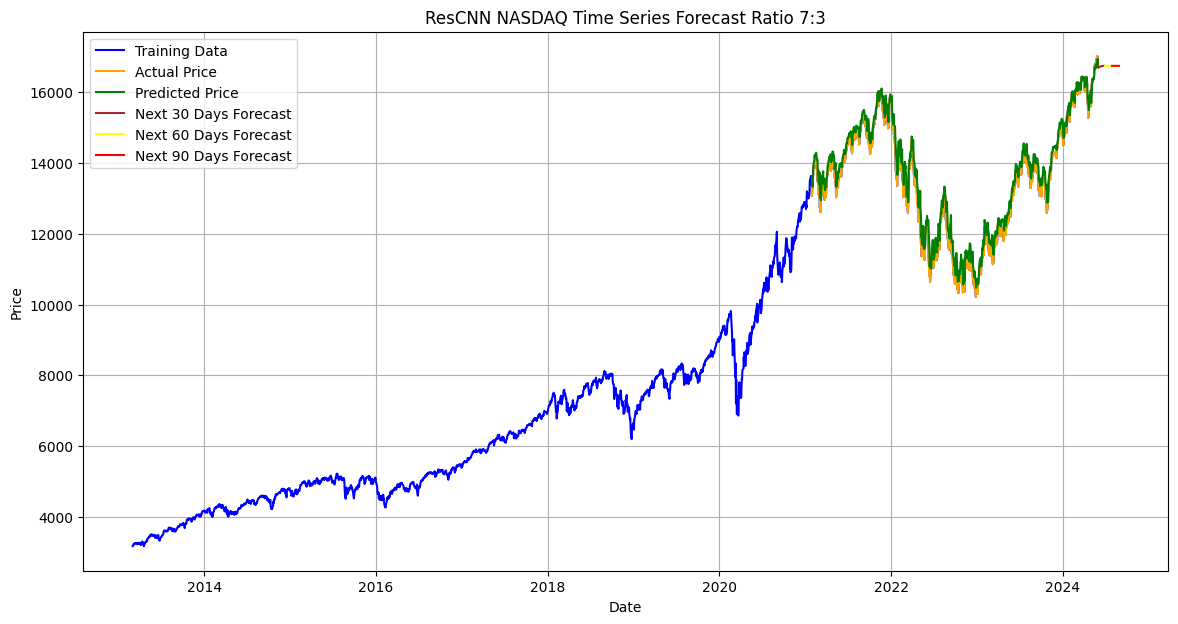

NASDAQ Results (Ratio 7:3): MAE: 0.0164, RMSE: 0.0204, MAPE: 2.33%
Epoch 1/100
71/71 [==============================] - 7s 29ms/step - loss: 0.0135 - val_loss: 0.0013
Epoch 2/100
71/71 [==============================] - 1s 18ms/step - loss: 3.3098e-04 - val_loss: 0.0014
Epoch 3/100
71/71 [==============================] - 1s 17ms/step - loss: 3.0328e-04 - val_loss: 0.0014
Epoch 4/100
71/71 [==============================] - 1s 16ms/step - loss: 3.2208e-04 - val_loss: 0.0012
Epoch 5/100
71/71 [==============================] - 1s 16ms/step - loss: 3.0818e-04 - val_loss: 8.4332e-04
Epoch 6/100
71/71 [==============================] - 1s 16ms/step - loss: 2.4649e-04 - val_loss: 8.2959e-04
Epoch 7/100
71/71 [==============================] - 1s 18ms/step - loss: 2.1963e-04 - val_loss: 0.0028
Epoch 8/100
71/71 [==============================] - 1s 16ms/step - loss: 4.3200e-04 - val_loss: 6.8985e-04
Epoch 9/100
71/71 [==============================] - 2s 25ms/step - loss: 1.7956e-04 - val_lo

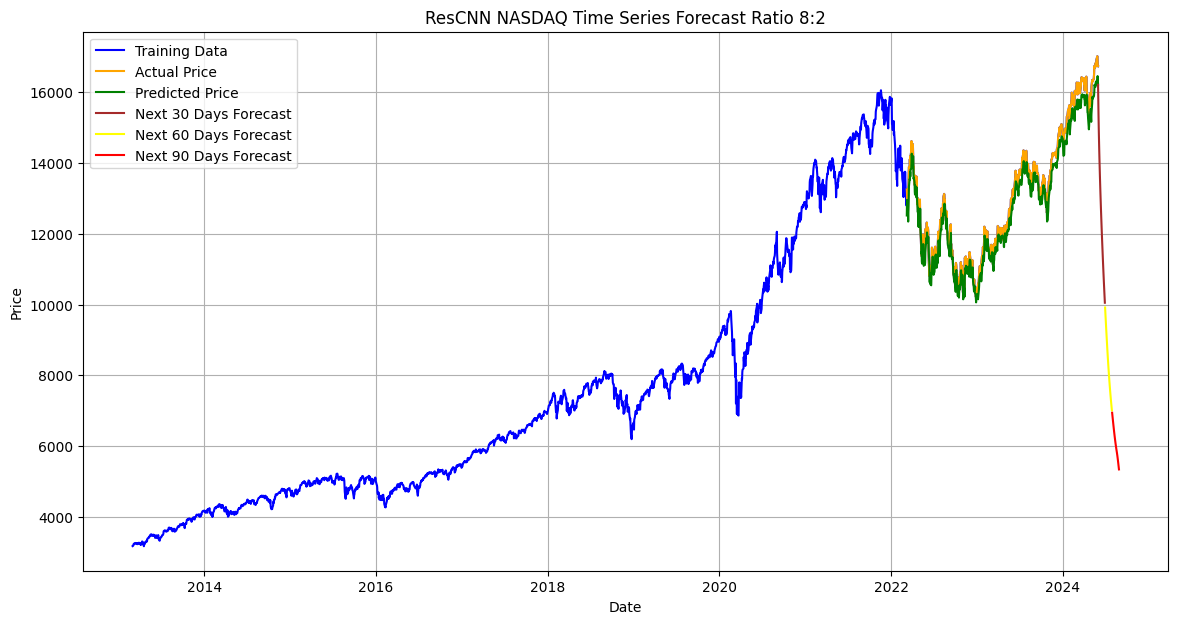

NASDAQ Results (Ratio 8:2): MAE: 0.0219, RMSE: 0.0254, MAPE: 3.01%
Epoch 1/100
53/53 [==============================] - 6s 31ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 2/100
53/53 [==============================] - 1s 22ms/step - loss: 9.6732e-05 - val_loss: 0.0030
Epoch 3/100
53/53 [==============================] - 1s 19ms/step - loss: 9.2281e-05 - val_loss: 0.0020
Epoch 4/100
53/53 [==============================] - 1s 22ms/step - loss: 8.5947e-05 - val_loss: 0.0037
Epoch 5/100
53/53 [==============================] - 1s 22ms/step - loss: 8.1841e-05 - val_loss: 0.0026
Epoch 6/100
53/53 [==============================] - 1s 24ms/step - loss: 7.8755e-05 - val_loss: 0.0015
Epoch 7/100
53/53 [==============================] - 1s 22ms/step - loss: 6.7146e-05 - val_loss: 0.0022
Epoch 8/100
53/53 [==============================] - 2s 31ms/step - loss: 7.1302e-05 - val_loss: 0.0024
Epoch 9/100
53/53 [==============================] - 2s 30ms/step - loss: 5.9730e-05 - val_loss: 0.0015
E

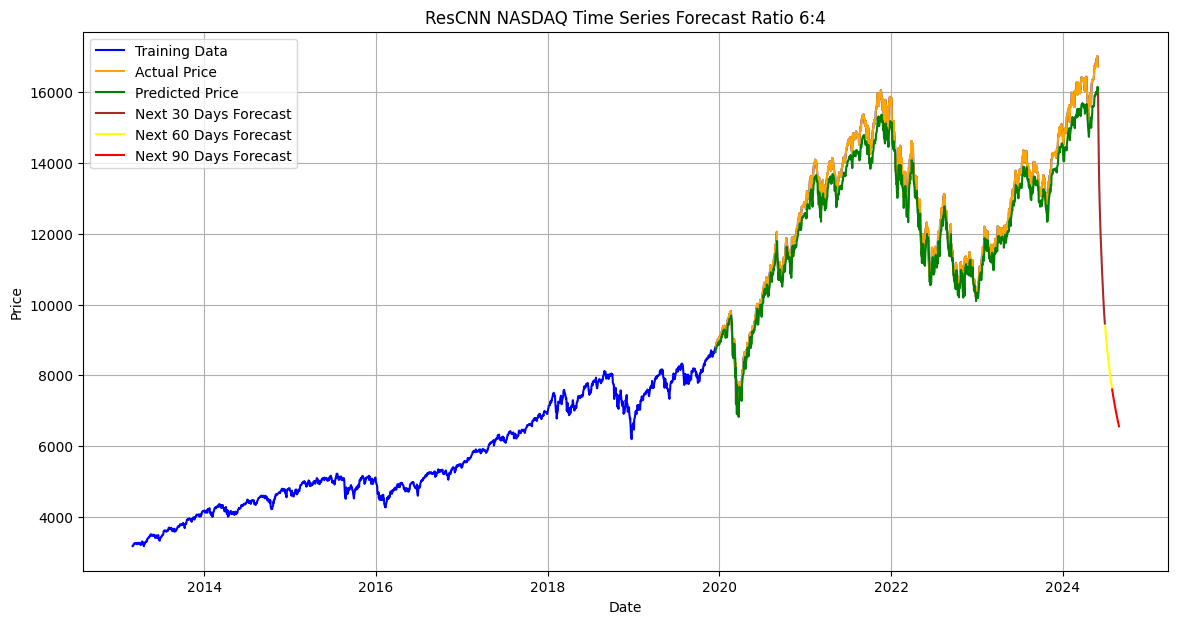

NASDAQ Results (Ratio 6:4): MAE: 0.0265, RMSE: 0.0309, MAPE: 3.71%
Epoch 1/100
63/63 [==============================] - 7s 44ms/step - loss: 0.0190 - val_loss: 0.0031
Epoch 2/100
63/63 [==============================] - 1s 19ms/step - loss: 7.9030e-04 - val_loss: 0.0024
Epoch 3/100
63/63 [==============================] - 1s 18ms/step - loss: 7.4434e-04 - val_loss: 0.0022
Epoch 4/100
63/63 [==============================] - 1s 18ms/step - loss: 7.4852e-04 - val_loss: 9.9107e-04
Epoch 5/100
63/63 [==============================] - 1s 18ms/step - loss: 5.7293e-04 - val_loss: 8.1720e-04
Epoch 6/100
63/63 [==============================] - 1s 18ms/step - loss: 4.9053e-04 - val_loss: 0.0010
Epoch 7/100
63/63 [==============================] - 1s 18ms/step - loss: 4.0554e-04 - val_loss: 0.0012
Epoch 8/100
63/63 [==============================] - 1s 18ms/step - loss: 3.6215e-04 - val_loss: 5.1233e-04
Epoch 9/100
63/63 [==============================] - 1s 18ms/step - loss: 3.0492e-04 - val_lo

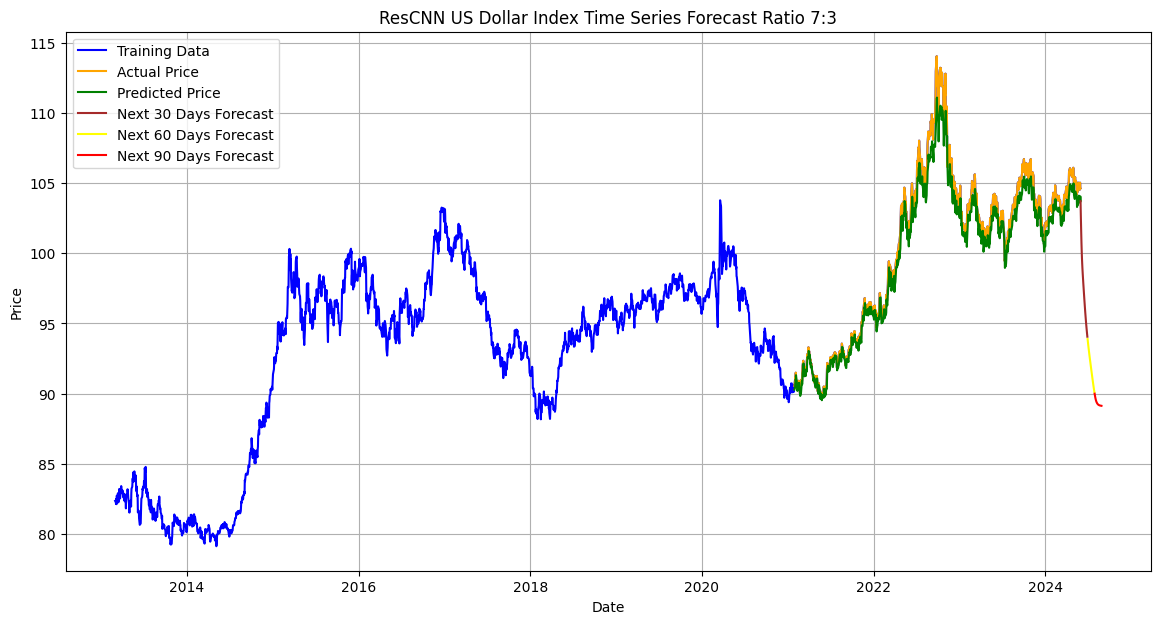

US Dollar Index Results (Ratio 7:3): MAE: 0.0220, RMSE: 0.0283, MAPE: 3.30%
Epoch 1/100
72/72 [==============================] - 8s 48ms/step - loss: 0.0168 - val_loss: 0.0028
Epoch 2/100
72/72 [==============================] - 2s 30ms/step - loss: 7.4119e-04 - val_loss: 0.0027
Epoch 3/100
72/72 [==============================] - 2s 24ms/step - loss: 6.6105e-04 - val_loss: 0.0021
Epoch 4/100
72/72 [==============================] - 1s 20ms/step - loss: 5.7497e-04 - val_loss: 0.0013
Epoch 5/100
72/72 [==============================] - 1s 20ms/step - loss: 5.3187e-04 - val_loss: 0.0011
Epoch 6/100
72/72 [==============================] - 1s 20ms/step - loss: 4.4734e-04 - val_loss: 0.0017
Epoch 7/100
72/72 [==============================] - 2s 22ms/step - loss: 3.4431e-04 - val_loss: 5.5289e-04
Epoch 8/100
72/72 [==============================] - 2s 21ms/step - loss: 2.6959e-04 - val_loss: 4.3934e-04
Epoch 9/100
72/72 [==============================] - 1s 20ms/step - loss: 2.4979e-04 - v

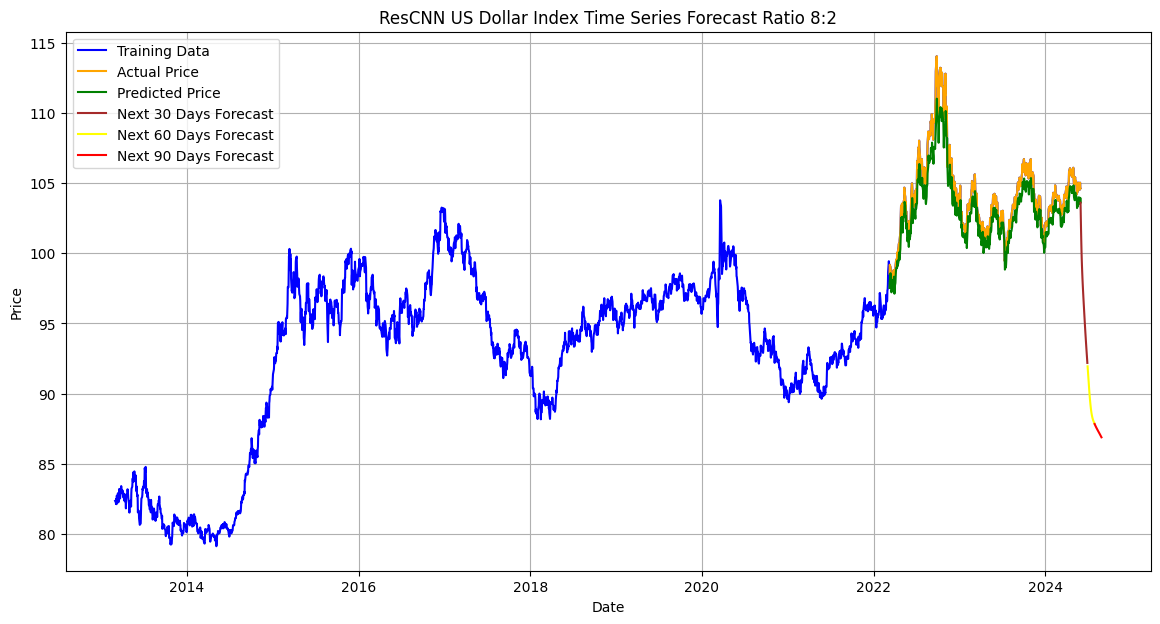

US Dollar Index Results (Ratio 8:2): MAE: 0.0309, RMSE: 0.0360, MAPE: 4.15%
Epoch 1/100
54/54 [==============================] - 5s 32ms/step - loss: 0.0117 - val_loss: 0.0013
Epoch 2/100
54/54 [==============================] - 1s 19ms/step - loss: 7.1719e-04 - val_loss: 0.0013
Epoch 3/100
54/54 [==============================] - 1s 19ms/step - loss: 7.3015e-04 - val_loss: 0.0017
Epoch 4/100
54/54 [==============================] - 1s 19ms/step - loss: 6.4652e-04 - val_loss: 0.0010
Epoch 5/100
54/54 [==============================] - 1s 20ms/step - loss: 5.8463e-04 - val_loss: 9.4030e-04
Epoch 6/100
54/54 [==============================] - 1s 22ms/step - loss: 5.4625e-04 - val_loss: 7.9842e-04
Epoch 7/100
54/54 [==============================] - 2s 30ms/step - loss: 4.7562e-04 - val_loss: 6.7657e-04
Epoch 8/100
54/54 [==============================] - 2s 33ms/step - loss: 4.1489e-04 - val_loss: 5.6375e-04
Epoch 9/100
54/54 [==============================] - 2s 31ms/step - loss: 3.2033

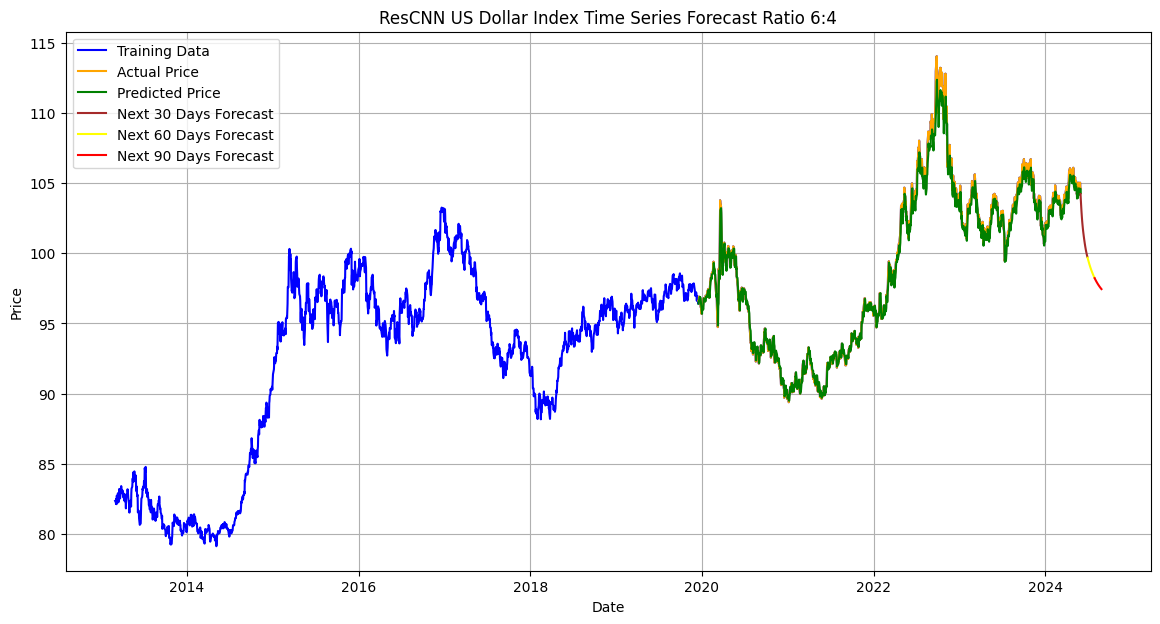

US Dollar Index Results (Ratio 6:4): MAE: 0.0120, RMSE: 0.0166, MAPE: 1.99%


In [30]:
# Process each dataset with different split ratios
for dataset_name, df in datasets.items():
    for split_ratio in split_ratios:
        results = process_dataset(df, dataset_name, split_ratio)
        print(f'{dataset_name} Results (Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}): MAE: {results["mae"]:.4f}, RMSE: {results["rmse"]:.4f}, MAPE: {results["mape"]:.2f}%')